<a href="https://colab.research.google.com/github/seirah-yang/BootCamp/blob/main/CNN_CustomDataset%EA%B5%90%EC%95%88_0903.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/tongpython/cat-and-dog/?select=test_set

In [1]:
#!unzip training_set.zip

In [ ]:
#!unzip test_set.zip

In [ ]:
#!rm -r /content/test_set/cats/.ipynb_checkpoints
#!rm -r /content/test_set/dogs/.ipynb_checkpoints
#!rm -r /content/training_set/cats/.ipynb_checkpoints
#!rm -r /content/training_set/dogs/.ipynb_checkpoints

# 오프라인 데이터 증강(Offline Data augmentation) - albumentations

In [ ]:
# https://github.com/albumentations-team/albumentations

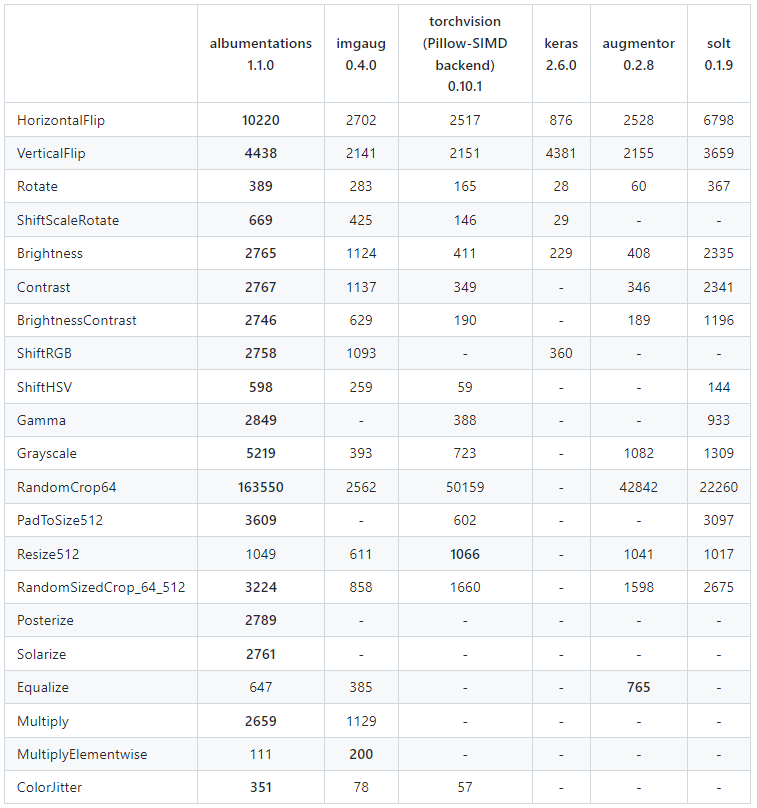

In [ ]:
!sudo rm -r training_set

In [2]:
!gdown --id 1iog5aaxqS_U9sOPPAgdIIly8pxSZ1Cf7

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iog5aaxqS_U9sOPPAgdIIly8pxSZ1Cf7
To: /content/data.zip
100% 9.05M/9.05M [00:00<00:00, 93.4MB/s]


In [3]:
!unzip data.zip

Archive:  data.zip
  inflating: training_set/cats/cat.1.jpg  
  inflating: training_set/cats/cat.10.jpg  
  inflating: training_set/cats/cat.100.jpg  
  inflating: training_set/cats/cat.11.jpg  
  inflating: training_set/cats/cat.12.jpg  
  inflating: training_set/cats/cat.13.jpg  
  inflating: training_set/cats/cat.14.jpg  
  inflating: training_set/cats/cat.15.jpg  
  inflating: training_set/cats/cat.16.jpg  
  inflating: training_set/cats/cat.17.jpg  
  inflating: training_set/cats/cat.18.jpg  
  inflating: training_set/cats/cat.19.jpg  
  inflating: training_set/cats/cat.2.jpg  
  inflating: training_set/cats/cat.20.jpg  
  inflating: training_set/cats/cat.21.jpg  
  inflating: training_set/cats/cat.22.jpg  
  inflating: training_set/cats/cat.23.jpg  
  inflating: training_set/cats/cat.24.jpg  
  inflating: training_set/cats/cat.25.jpg  
  inflating: training_set/cats/cat.26.jpg  
  inflating: training_set/cats/cat.27.jpg  
  inflating: training_set/cats/cat.28.jpg  
  inflating: t

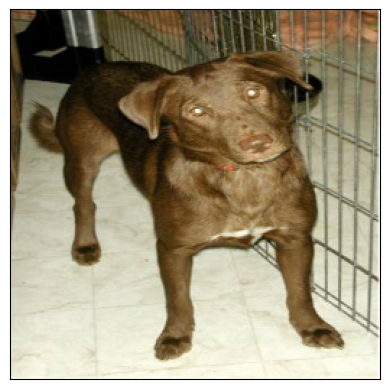

In [11]:
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image

image = plt.imread('/content/training_set/dogs/dog.1.jpg')

transform = A.Compose([ # 앨버멘테이션의 전처리 파이프라인을 만들때 Compose를 쓴다.
    A.Resize(256, 256),
    A.Blur(p=0.5), # p = probability
    A.HorizontalFlip(p=1),
])

transformed = transform(image=image)

transformed_image = transformed['image']
im = Image.fromarray(transformed_image)
im.save("test.jpg")
plt.imshow(transformed_image)
plt.xticks([]); plt.yticks([])
plt.show()


In [12]:
# 오프라인 어그멘테이션 코드
import os
from os import path # trainig_set 폴더에 있는 이미지들을 조회하기 위해 os 라이브러리를 import

transform = A.Compose([  #엘버맨텐이션 전처리 파이프라인
  A.Resize(256, 256),
  A.Blur(p=0.5),
  #A.HorizontalFlip(p=1),
])

if not path.exists("./aug"): # 현재 작업디렉토리에 aug 폴더가 없으면 만들어라.
  os.mkdir("./aug")

classes = os.listdir("./training_set") #os.listdir은 인자로 들어온 path의 파일 list를 가져옴
                                       # training_set안에 있는 폴더들 조회하려고.
                                      # classes 변수에는 cats dog을 문자열로 반환
print(classes)


['dogs', 'cats']


In [15]:
for label in range(len(classes)): # [cats, dogs] 조회하려고
    class_folder = os.path.join("./training_set",classes[label]) # 첫번째 이터레이션에서
                                                                # ./traning_set/dogs가
                                                                # class_folder 변수에 저장.
    for filename in os.listdir(class_folder): # os.listdir("./traning_set/dogs") 안에 있는 파일 이름을
                                             # 차례대로 filename 변수에 반환.
        img_path = os.path.join(class_folder, filename) # ./traning_set/dogs/dog.1.jpg
        image = plt.imread(img_path) # 이미지 로드
        transformed = transform(image=image) # 변환

        transformed_image = transformed['image'] # 인덱싱
        im = Image.fromarray(transformed_image) # 행렬 -> 이미지 타입 변환
        im.save("./aug/"+"trans_"+filename) # aug/ 폴더에 저장.

# CNN 모델 학습 (이미지 100장으로만 학습)

In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torch import nn, optim
from PIL import Image
import torchvision.transforms as T

In [17]:
class CustomDataset(Dataset): # 파이토치 학습 코드에서 데이터 불러오는 최근 방식
                              # from torch.utils.data import Dataset이거를 상속 꼭 받아야함.
    def __init__(self, root_dir, transform=None): # 루트경로, trasform 할건지 말건지
        self.root_dir = root_dir # 루트 디렉토리 path 정의.
        self.transform = transform # self.transform = A.Compose([  #엘버맨텐이션 전처리 파이프라인
                                   #                   A.Resize(256, 256),
                                   #                   A.Blur(p=0.5),
                                   #                   #A.HorizontalFlip(p=1),
                                   #                  ])
        self.classes = os.listdir(root_dir) # 루트디렉토리에 있는 클래스폴더
                                            # 루트디렉토리는 training_set 폴더이기 때문에. self.classes = [cats, dogs]
        self.data = [] #이미지 path를 저장할 빈리스트

        for label in range(len(self.classes)): # label변수는 이터레이션 돌면서 dogs, cats로 바뀔것

            class_folder = os.path.join(root_dir, self.classes[label]) # class_folder = ./training_set/cats 이런식으로 바뀌겠죠?

            for filename in os.listdir(class_folder): # ./training_set/cats 폴더 안에 있는 이미지들을 filename 변수에 순차적으로 대입.
                img_path = os.path.join(class_folder, filename) # ./training_set/cats/cats.1.jpg
                self.data.append((img_path, label)) # self.data.append([./training_set/cats/cats.1.jpg , 'cats])

    def __len__(self): # CustomDataset 객체를 가지고 길이를 호출하는 연산을 할때 자동으로 호출되는 특수메서드.
        return len(self.data) # self.data의 길이를 반환

    def __getitem__(self, idx): # CustomDataset에서 데이터를 불러오는 특수 메소드
                                # 이게 발동되는 시점은 for idx, data in enumerate(dataloader): 코드에서 발동됨.
                                # 또는 dataloader에 있는 데이터를 호출할때. next(iter(dataloader))는 dataloader에서 첫번째 데이터를 불러올때 씀.
                                # 이때도 발동됨.

        img_path, label = self.data[idx] # self.data = [['./training_set/cats/cats.1.jpg', 0]
                                                      #  './training_set/cats/cats.2.jpg', 0]]

        # img_path='./training_set/cats/cats.1.jpg'
        # label = 0

        image = Image.open(img_path) # './training_set/cats/cats.1.jpg' 이미지 load

        if self.transform: # 객체를 만들때 self.transform 정의 했다면(존재한다면),
            image = self.transform(image) # 넣어준 앨버멘테이션 transform 적용 (이미지 transform)
        return image, label


In [18]:
data_dir = "."  # 현재 작업 디렉토리로 설정
batch_size = 32
transform = T.Compose([ # torchvision의 전처리 코드
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [19]:
                              # ./training_set
train_dataset = CustomDataset(os.path.join(data_dir, 'training_set'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(os.path.join(data_dir, 'test_set'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(56 * 56 * 64, 2, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [21]:
# CNN 모델 정의
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader: # Custom dataset에서 데이터를 1배치묶음씩 가져온다. -> __getitem__ 함수가 호출되겠다.


        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


torch.save(model.state_dict(), 'cnn_model.pth')

Epoch 1/10, Loss: 0.7285071185656956
Epoch 2/10, Loss: 0.6369264892169407
Epoch 3/10, Loss: 0.7025803583008903
Epoch 4/10, Loss: 0.651826628616878
Epoch 5/10, Loss: 0.5308155800615039
Epoch 6/10, Loss: 0.3781059299196516
Epoch 7/10, Loss: 0.3633847492081778
Epoch 8/10, Loss: 0.3295947653906686
Epoch 9/10, Loss: 0.27256493057523457
Epoch 10/10, Loss: 0.19780925129141128


In [22]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')

Accuracy on test set: 54.5%
